# Problem Definition

Sebagai Data Scientist di ID/X Partners, Anda akan terlibat dalam sebuah proyek dari perusahaan pemberi pinjaman (multifinance).

Client anda ingin **meningkatkan keakuratan** dalam ***menilai dan mengelola risiko kredit***, sehingga dapat mengoptimalkan keputusan bisnis mereka dan mengurangi potensi kerugian.

**Tujuan:** mengembangkan model machine learning yang dapat memprediksi risiko kredit (credit risk) berdasarkan dataset yang disediakan, yang mencakup data pinjaman yang disetujui dan ditolak.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Collection

### Libraries

In [ ]:
!pip install category_encoders --quiet
!pip install lightgbm catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.2 MB/s eta 0:00:00


In [ ]:
from datetime import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Warning output handling
import warnings

# Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce

# Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Clustering
from sklearn.cluster import KMeans

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Data Splitting
from sklearn.model_selection import train_test_split

# Oversampling
from imblearn.over_sampling import SMOTE

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Training
from sklearn import metrics

# Export model
import joblib

# Precision and Recall
from sklearn.metrics import precision_score, recall_score

# ROC dan AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Settings

In [ ]:
# Atur pandas untuk menampilkan semua kolom
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Atur output warning
warnings.filterwarnings('ignore')

# Atur random state dari SMOTE
smote = SMOTE(random_state=42)

### Read Dataset

In [ ]:
# def copy_csv_data(nama_file, jumlah_data):
#     """
#     Membaca file CSV dari path tertentu, menyalin sejumlah data ke DataFrame baru,
#     dan menyimpannya kembali sebagai file CSV baru.

#     Parameters:
#     nama_file (str): Nama file CSV tanpa ekstensi .csv
#     jumlah_data (int): Jumlah data yang ingin disalin ke DataFrame baru
#     """
#     # Menggunakan string template untuk menentukan path file
#     file_path = f'/content/{nama_file}'

#     # Membaca file CSV dan mengonversinya menjadi DataFrame
#     df = pd.read_csv(file_path)

#     # Menyalin sejumlah data pertama ke DataFrame baru
#     df_new = df.head(jumlah_data)

#     # Menyimpan DataFrame baru dalam bentuk CSV
#     new_file_path = f'/content/new_{nama_file}.csv'
#     df_new.to_csv(new_file_path, index=False)

#     # Menampilkan pesan bahwa file telah disimpan
#     print(f'File baru telah disimpan di: {new_file_path}')

# # Contoh penggunaan fungsi
# copy_csv_data("loan_data_2007_2014.csv", 20000)

In [ ]:
'''
* Data utama yaitu file loan_data_2007_2014.csv
* 466285 data
'''
# UNTUK DEVELOPMENT
# 200 data
# df = pd.read_csv("/content/loan_data_200.csv")

# 5000 data
# df = pd.read_csv("/content/loan_data_5000.csv")

# 20000 data
# df = pd.read_csv("/content/loan_data_20000.csv")

# UNTUK PRODUCTION
# df = pd.read_csv("/content/loan_data_2007_2014")
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Data/loan_data_2007_2014.csv")

# Data Understanding

In [ ]:
# Dimensi dataset
df.shape

print(f'Jumlah baris: {df.shape[0]}')
print(f'Jumlah kolom: {df.shape[1]}')

Jumlah baris: 466285
Jumlah kolom: 75


In [ ]:
column_descriptions = {
    'Unnamed: 0': 'Index',
    'id': 'Loan ID',
    'member_id': 'Member ID',
    'loan_amnt': 'Loan Amount',
    'funded_amnt': 'Funded Amount',
    'funded_amnt_inv': 'Funded Amount by Investors',
    'term': 'Loan Term',
    'int_rate': 'Interest Rate',
    'installment': 'Installment Amount',
    'grade': 'Loan Grade',
    'sub_grade': 'Loan Subgrade',
    'emp_title': 'Employment Title',
    'emp_length': 'Employment Length',
    'home_ownership': 'Home Ownership Status',
    'annual_inc': 'Annual Income',
    'verification_status': 'Income Verification Status',
    'issue_d': 'Issue Date',
    'loan_status': 'Loan Status',
    'pymnt_plan': 'Payment Plan',
    'url': 'URL',
    'desc': 'Description',
    'purpose': 'Loan Purpose',
    'title': 'Loan Title',
    'zip_code': 'ZIP Code',
    'addr_state': 'State',
    'dti': 'Debt-to-Income Ratio',
    'delinq_2yrs': 'Delinquencies in Last 2 Years',
    'earliest_cr_line': 'Earliest Credit Line',
    'inq_last_6mths': 'Credit Inquiries in Last 6 Months',
    'mths_since_last_delinq': 'Months Since Last Delinquency',
    'mths_since_last_record': 'Months Since Last Public Record',
    'open_acc': 'Number of Open Accounts',
    'pub_rec': 'Number of Public Records',
    'revol_bal': 'Revolving Balance',
    'revol_util': 'Revolving Utilization',
    'total_acc': 'Total Accounts',
    'initial_list_status': 'Initial List Status',
    'out_prncp': 'Outstanding Principal',
    'out_prncp_inv': 'Outstanding Principal for Investors',
    'total_pymnt': 'Total Payment',
    'total_pymnt_inv': 'Total Payment by Investors',
    'total_rec_prncp': 'Total Principal Received',
    'total_rec_int': 'Total Interest Received',
    'total_rec_late_fee': 'Total Late Fees Received',
    'recoveries': 'Recoveries',
    'collection_recovery_fee': 'Collection Recovery Fee',
    'last_pymnt_d': 'Last Payment Date',
    'last_pymnt_amnt': 'Last Payment Amount',
    'next_pymnt_d': 'Next Payment Date',
    'last_credit_pull_d': 'Last Credit Pull Date',
    'collections_12_mths_ex_med': 'Collections in Last 12 Months Excluding Medical',
    'mths_since_last_major_derog': 'Months Since Last Major Derogatory',
    'policy_code': 'Policy Code',
    'application_type': 'Application Type',
    'annual_inc_joint': 'Joint Annual Income',
    'dti_joint': 'Joint Debt-to-Income Ratio',
    'verification_status_joint': 'Joint Verification Status',
    'acc_now_delinq': 'Accounts Now Delinquent',
    'tot_coll_amt': 'Total Collection Amount',
    'tot_cur_bal': 'Total Current Balance',
    'open_acc_6m': 'Open Accounts in Last 6 Months',
    'open_il_6m': 'Open Installment Loans in Last 6 Months',
    'open_il_12m': 'Open Installment Loans in Last 12 Months',
    'open_il_24m': 'Open Installment Loans in Last 24 Months',
    'mths_since_rcnt_il': 'Months Since Recent Installment Loan',
    'total_bal_il': 'Total Balance on Installment Loans',
    'il_util': 'Installment Loan Utilization',
    'open_rv_12m': 'Open Revolving Accounts in Last 12 Months',
    'open_rv_24m': 'Open Revolving Accounts in Last 24 Months',
    'max_bal_bc': 'Maximum Balance on Bankcard',
    'all_util': 'Utilization on All Accounts',
    'total_rev_hi_lim': 'Total Revolving High Credit Limit',
    'inq_fi': 'Inquiries in Last 12 Months',
    'total_cu_tl': 'Total Credit Union Trades',
    'inq_last_12m': 'Inquiries in Last 12 Months'
}

In [ ]:
# Fungsi untuk menampilkan jumlah persentase missing value di setiap kolom
# Nilai missing value di setiap kolom diurutkan dari yang terbesar hingga terkecil
def show_missing_value_percentage(df):
    # Menghitung jumlah total missing values di setiap kolom
    missing_values = df.isnull().sum()

    # Menghitung persentase missing values di setiap kolom
    missing_percentage = (missing_values / len(df)) * 100

    y = pd.Series(missing_percentage)
    sorted_y = y.sort_values(ascending=False)

    missing_values = {}
    for i in sorted_y.index:
      value = round(y[i])
      missing_values[i] = str(value) + '%'

    missing_value_vis = pd.DataFrame(list(missing_values.items()), columns=['Key', 'Value'])
    print(missing_value_vis)

show_missing_value_percentage(df)

                            Key Value
0                  inq_last_12m  100%
1                  total_bal_il  100%
2                     dti_joint  100%
3     verification_status_joint  100%
4              annual_inc_joint  100%
5                   open_acc_6m  100%
6                    open_il_6m  100%
7                   open_il_12m  100%
8                   open_il_24m  100%
9            mths_since_rcnt_il  100%
10                      il_util  100%
11                  open_rv_24m  100%
12                  total_cu_tl  100%
13                       inq_fi  100%
14                   max_bal_bc  100%
15                     all_util  100%
16                  open_rv_12m  100%
17       mths_since_last_record   87%
18  mths_since_last_major_derog   79%
19                         desc   73%
20       mths_since_last_delinq   54%
21                 next_pymnt_d   49%
22                  tot_cur_bal   15%
23                 tot_coll_amt   15%
24             total_rev_hi_lim   15%
25          

In [ ]:
# Ringkasan statistik dasar
df.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,215934.000000,62638.000000,466256.000000,466256.000000,4.662850e+05,465945.000000,466256.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466140.000000,98974.000000,466285.0,0.0,0.0,0.0,466256.000000,3.960090e+05,3.960090e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,34.104430,74.306012,11.187069,0.160564,1.623020e+04,56.176947,25.064430,4410.062342,4408.452258,11540.686220,11469.892747,8866.014657,2588.677225,0.650129,85.344211,8.961534,3123.913796,0.009085,42.852547,1.0,NaN,NaN,NaN,0.004002,1.919135e+02,1.388017e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,21.778487,30.357653,4.987526,0.510863,2.067625e+04,23.732628,11.600141,6355.078769,6353.198001,8265.627112,8254.157579,7031.687997,2483.809661,5.265730,552.216084,85.491437,5554.737393,0.108648,21.662591,0.0,NaN,NaN,NaN,0.068637,1.463021e+04,1.521147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,53.000000,8.000000,0.000000,6.413000e+03,39.200000,17.000000,0.000000,0.000000,5552.125349,5499.250000,3708.560000,957.280000,0.000000,0.000000,0.000000,312.620000,0.000000,26.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.861800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,31.000000,76.000000,10.000000,0.000000,1.176400e+04,57.600000,23.000000,441.470000,441.380000,9419.250943,9355.430000,6817.760000,1818.880000,0.000000,0.000000,0.000000,545.960000,0.000000,42.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,8.153900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,49.000000,102.000000,14.000000,0.000000,2.033300e+04,74.700000,32.000000,7341.650000,7338.390000,15308.158460,15231.310000,12000.000000,3304.530000,0.000000,0.000000,0.000000,3187.510000,0.000000,59.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.089530e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
# Melihat jumlah nilai unik pada setiap kolom
df.nunique().sort_values(ascending=False)

Unnamed: 0                     466285
url                            466285
member_id                      466285
id                             466285
total_pymnt                    351609
total_pymnt_inv                347659
total_rec_int                  270249
tot_cur_bal                    220690
emp_title                      205475
last_pymnt_amnt                198194
total_rec_prncp                172713
out_prncp_inv                  141189
out_prncp                      135665
desc                           124435
title                           63098
revol_bal                       58142
installment                     55622
annual_inc                      31901
recoveries                      22773
collection_recovery_fee         20275
total_rev_hi_lim                14612
funded_amnt_inv                  9854
tot_coll_amt                     6321
total_rec_late_fee               5808
dti                              3997
funded_amnt                      1354
loan_amnt   

# First Data Preparation


*   Menangani missing values
*   Menghapus atribut-atribut dengan jumlah data unik hanya satu data unik
*   Menghapus atribut-atribut dengan jumlah data unik sebanyak jumlah data



### Menangani missing values

In [ ]:
def clean_dataframe(df, threshold=0.6):
    """
    Fungsi untuk membersihkan DataFrame dengan menghapus kolom yang memiliki missing values
    lebih dari atau sama dengan threshold yang ditentukan.

    Parameters:
    df (pd.DataFrame): DataFrame yang akan dibersihkan
    threshold (float): Ambang batas untuk menghapus kolom (persentase missing values)

    Returns:
    pd.DataFrame: DataFrame yang sudah dibersihkan
    """
    # Menghitung jumlah total missing values di setiap kolom
    missing_values = df.isnull().sum()

    # Menghitung persentase missing values di setiap kolom
    missing_percentage = missing_values / len(df)

    # Mendapatkan kolom yang harus dihapus (persentase missing values >= threshold)
    cols_to_drop = missing_percentage[missing_percentage >= threshold].index

    # Menghapus kolom yang memiliki persentase missing values lebih dari atau sama dengan threshold
    df_cleaned = df.drop(columns=cols_to_drop)

    return df_cleaned

# Membersihkan DataFrame menggunakan fungsi clean_dataframe
df_cleaned = clean_dataframe(df, threshold=0.6)

mungkin ini bisa pakai fungsi polimorfism

### Menghapus atribut-atribut dengan jumlah data unik hanya satu data unik dan atribut-atribut dengan jumlah data unik sebanyak jumlah data

In [ ]:
# Mengambil variabel yang berisi seluruh jumlah nilai unik (unique value) dari setiap kolom
df_cleaned_unique = df_cleaned.nunique().sort_values(ascending=False)

# Mendapatkan name kolom-kolom yang berisi hanya satu nilai unik
non_unique_columns = []

for col in df_cleaned_unique.index:
  if df_cleaned_unique[col] == 1:
    non_unique_columns.append(col)
    # print(f"{col}")

# Menghapus seluruh kolom yang hanya memiliki satu nilai unik
df_cleaned = df_cleaned.drop(columns=non_unique_columns)

# Mendapatkan name kolom-kolom yang memiliki jumlah nilai unik sebanyak jumlah data
super_unique_columns = []

for col in df_cleaned_unique.index:
  if df_cleaned_unique[col] == len(df_cleaned):
    super_unique_columns.append(col)
    # print(f"{col}")

# Menghapus seluruh kolom yang hanya memiliki jumlah nilai unik sebanyak jumlah data
df_cleaned = df_cleaned.drop(columns=super_unique_columns)

# Exploratory Data Analysis

In [ ]:
# Jika True maka semua nilai NaN akan dihapus
nonNaN = True
# nonNaN = False

# Drop rows with NaN values and reset index
if nonNaN:
  df_cleaned = df_cleaned.dropna().reset_index(drop=True)

In [ ]:
# Select numeric columns
numeric_df = df_cleaned.select_dtypes(include=['number'])

# Select categorical columns
categorical_df = df_cleaned.select_dtypes(include=['object'])

### Numerical Data

In [ ]:
print(f'Jumlah baris: {numeric_df.shape[0]}')
print(f'Jumlah kolom: {numeric_df.shape[1]}')

Jumlah baris: 106883
Jumlah kolom: 30


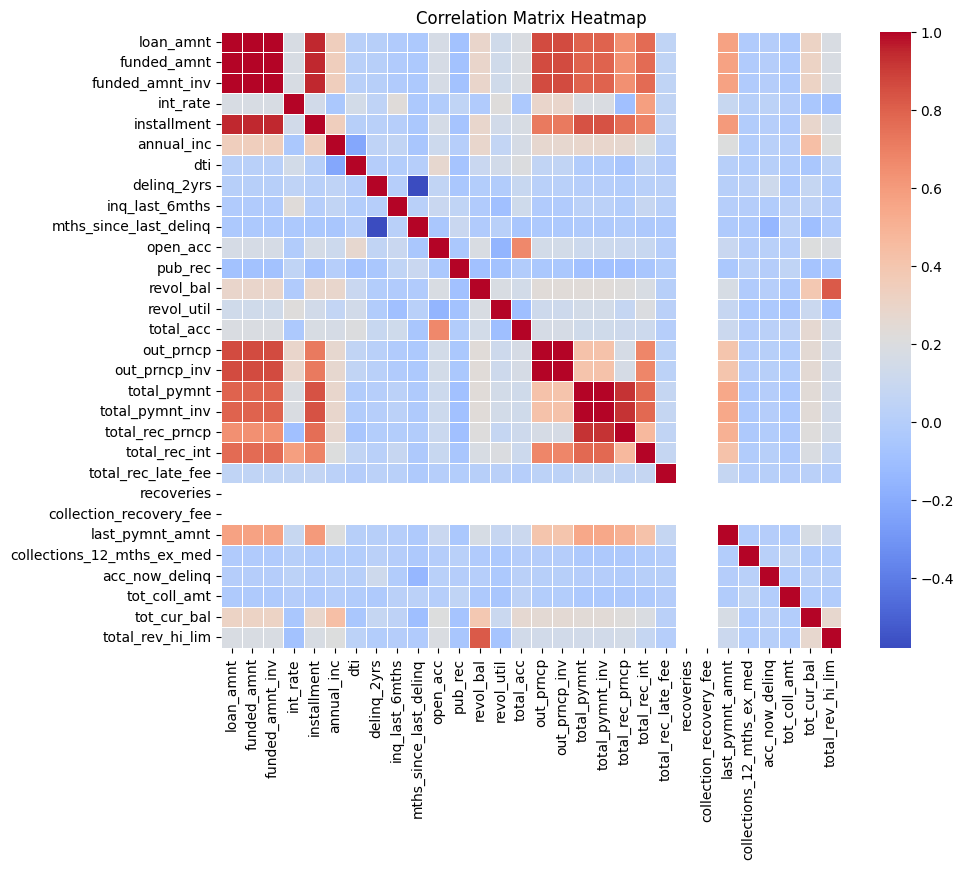

In [ ]:
# Correlation matrix untuk melihat semua nilai korelasi pada setiap kolom-kolom numerik

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".1f", linewidths=0.5)

# Add a title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

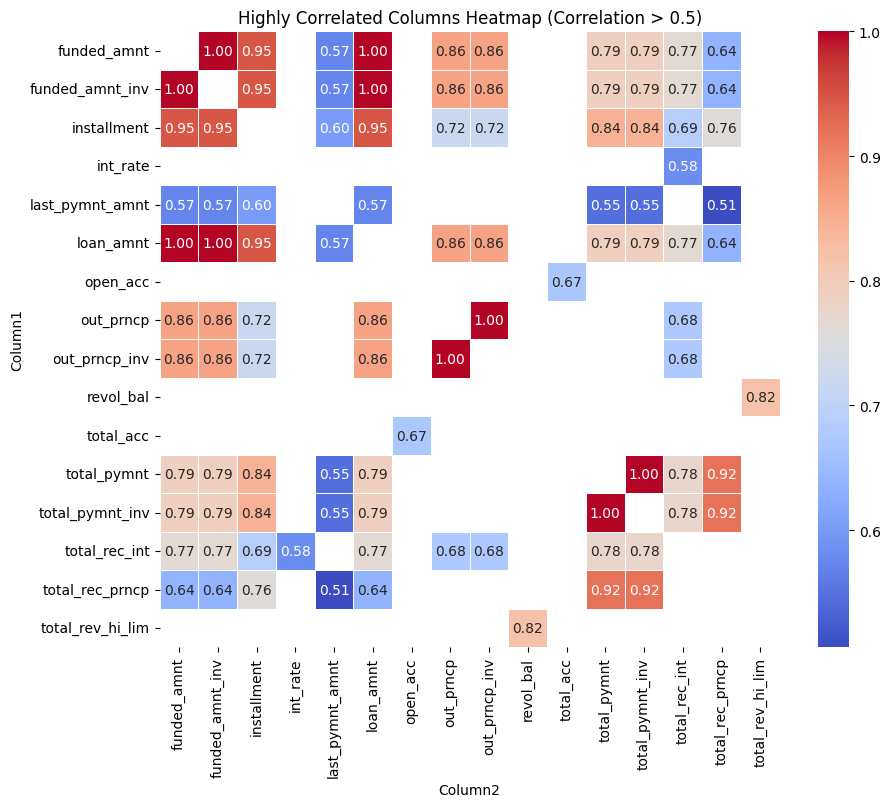

In [ ]:
# Menghasilkan grafik heatmap korelasi yang berisi kolom-kolom dengan nilai korelasi lebih dari 0.5

def show_only_high_corr_value(df, threshold = 0.5):
  # Compute the correlation matrix
  corr_matrix = df.corr()

  # Filter columns based on correlation threshold (e.g., 0.5)
  high_corr_pairs = corr_matrix[corr_matrix > 0.5].stack().reset_index().query('level_0 != level_1')
  high_corr_pairs.columns = ['Column1', 'Column2', 'Correlation']
  high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.5]

  # Create a pivot table for the heatmap
  heatmap_data = high_corr_pairs.pivot_table(index='Column1', columns='Column2', values='Correlation')

  # Set up the matplotlib figure
  plt.figure(figsize=(10, 8))

  # Create the heatmap
  sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

  # Add a title
  plt.title('Highly Correlated Columns Heatmap (Correlation > 0.5)')

  # Show the plot
  plt.show()

  return high_corr_pairs

high_corr_pairs_0_5 = show_only_high_corr_value(numeric_df, 0.6)

In [ ]:
numeric_df_unique = numeric_df.nunique().sort_values(ascending=False)

# Mendapatkan name kolom-kolom yang berisi hanya satu nilai unik
half_unique_columns = []

for col in numeric_df_unique.index:
  if numeric_df_unique[col] > int(len(numeric_df)/2):
    half_unique_columns.append(col)
    print(f"{col}")

# Menghapus seluruh kolom yang hanya memiliki satu nilai unik
numeric_df = numeric_df.drop(columns=half_unique_columns)

tot_cur_bal
total_pymnt_inv
total_pymnt
total_rec_int
out_prncp_inv
out_prncp
total_rec_prncp


### Categorical Data

In [ ]:
print(f'Jumlah baris: {categorical_df.shape[0]}')
print(f'Jumlah kolom: {categorical_df.shape[1]}')

Jumlah baris: 106883
Jumlah kolom: 19


# Second Data Preparation

Pengukuran outliers secara kuantitatif dapat dilakukan dengan teknik statistik seperti metode Z-score dan metode IQR (Interquartile Range).

1. Z-score Method
The Z-score method identifies outliers by calculating the number of standard deviations a data point is from the mean. Data points with a Z-score greater than a specified threshold (typically 3) are considered outliers.

2. IQR Method
The IQR method identifies outliers by calculating the interquartile range (IQR) and defining outliers as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

### Outliers handling

In [ ]:
def calculate_outliers(df, z_threshold=3, iqr_multiplier=1.5):
    """
    Calculate outliers in a DataFrame using both Z-score and IQR methods.

    Parameters:
    - df: DataFrame with numerical data.
    - z_threshold: Z-score threshold for identifying outliers (default is 3).
    - iqr_multiplier: Multiplier for IQR method (default is 1.5).

    Returns:
    - DataFrame with the count of outliers for each method.
    """
    outliers_info = pd.DataFrame(index=df.columns, columns=['Z-score Outliers', 'IQR Outliers'])

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            # Z-score method
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
            z_outliers = z_scores > z_threshold
            outliers_info.at[column, 'Z-score Outliers'] = z_outliers.sum()

            # IQR method
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            iqr_lower_bound = Q1 - iqr_multiplier * IQR
            iqr_upper_bound = Q3 + iqr_multiplier * IQR
            iqr_outliers = (df[column] < iqr_lower_bound) | (df[column] > iqr_upper_bound)
            outliers_info.at[column, 'IQR Outliers'] = iqr_outliers.sum()

    return outliers_info

outliers_info = calculate_outliers(numeric_df)
print(outliers_info)

                           Z-score Outliers IQR Outliers
loan_amnt                                 0            0
funded_amnt                               0            0
funded_amnt_inv                           0            0
int_rate                                  0          649
installment                            1432         2708
annual_inc                             1065         4826
dti                                       0            0
delinq_2yrs                            1560         6184
inq_last_6mths                         2393         7245
mths_since_last_delinq                   44           46
open_acc                               1199         3217
pub_rec                                3116        16245
revol_bal                              1015         5335
revol_util                               12           11
total_acc                              1000         1988
total_rec_late_fee                     1470         2118
recoveries                     

In [ ]:
def detect_and_plot_outliers(df):
    # Menghitung IQR dan mendeteksi outlier
    outliers = pd.DataFrame()
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_in_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers = pd.concat([outliers, outliers_in_col])

    # Membuat box plot untuk setiap kolom numerik
    df.select_dtypes(include=['float64', 'int64']).boxplot(figsize=(10, 8))
    plt.xticks(rotation=90)
    plt.show()

    return outliers

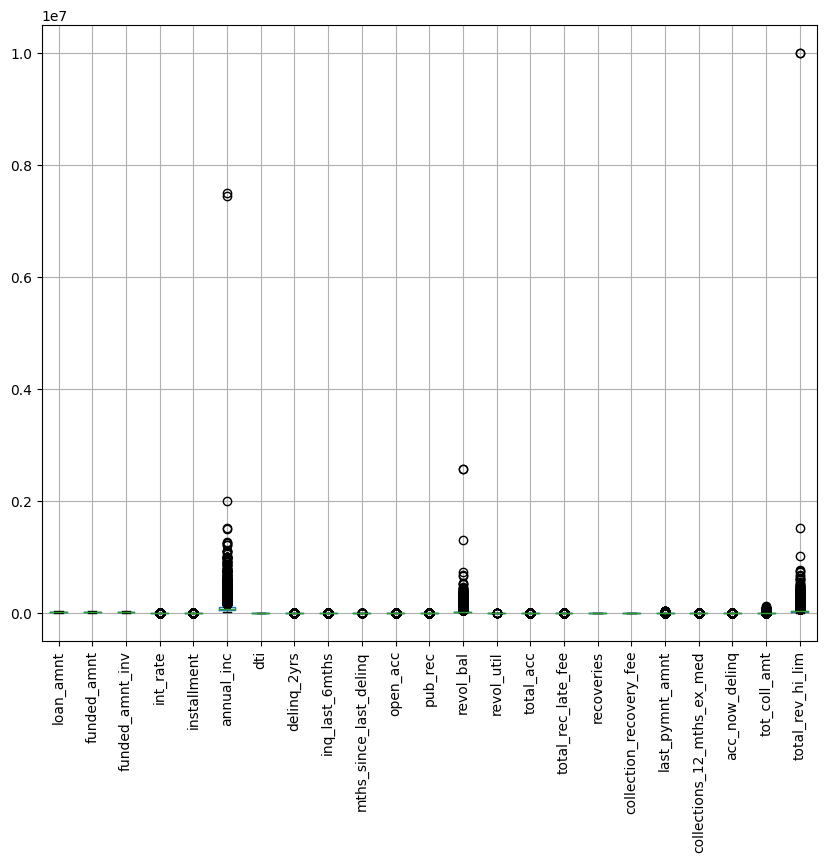

In [ ]:
# Deteksi dan plot outlier
outliers = detect_and_plot_outliers(numeric_df)

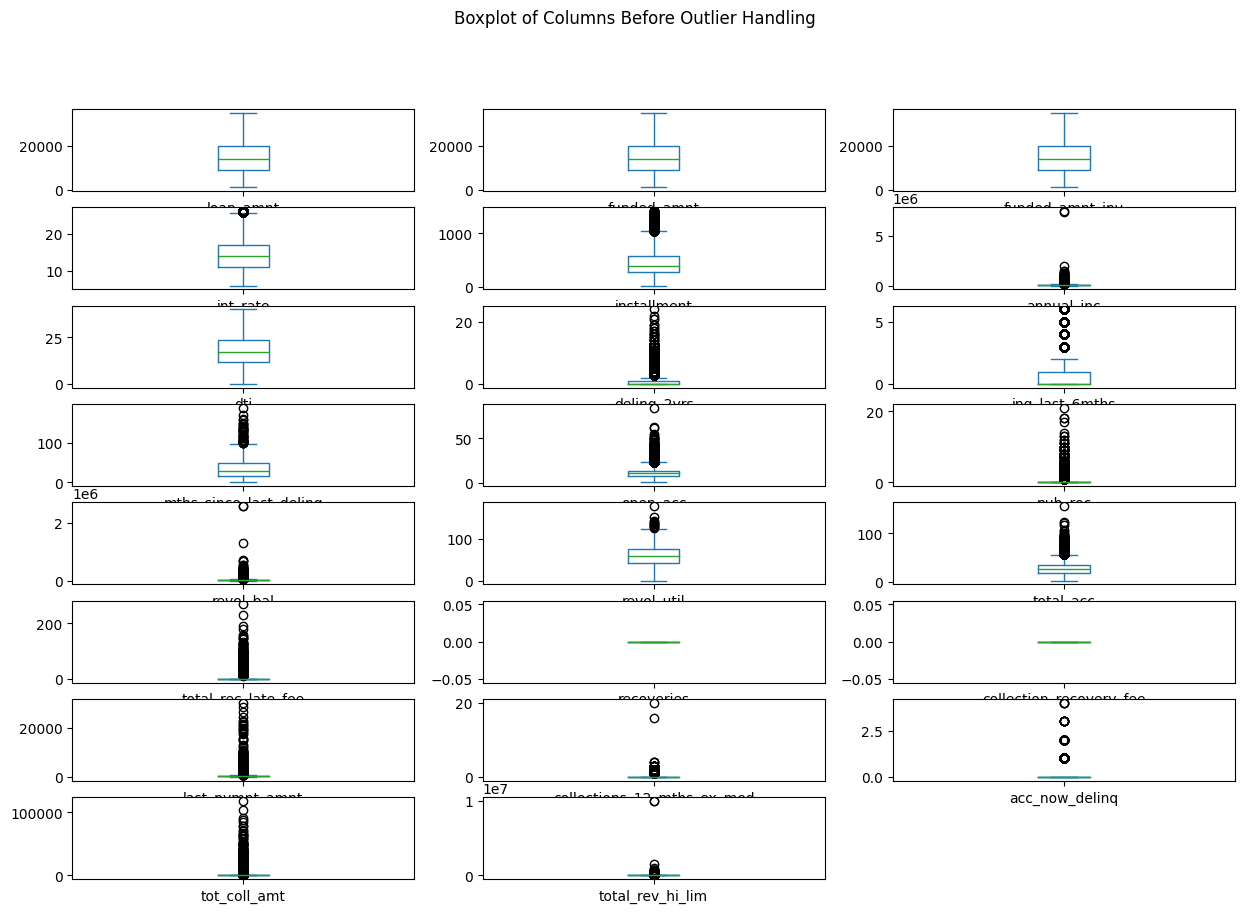

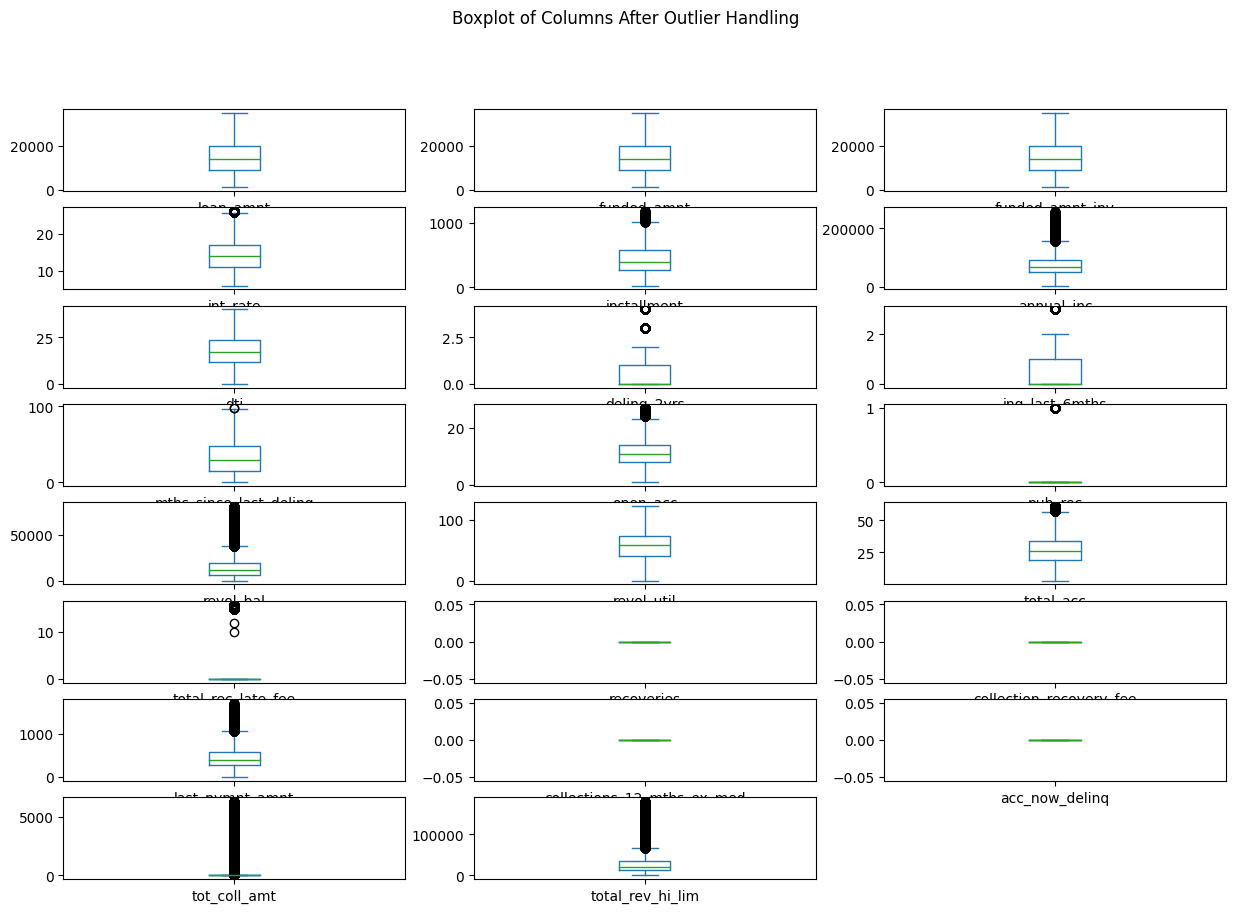

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

def handle_outliers(df, threshold=3, method='median'):
    """
    Handle outliers in a DataFrame by replacing them with the specified method.

    Parameters:
    - df: DataFrame containing the data.
    - threshold: Z-score threshold for identifying outliers (default is 3).
    - method: Method for replacing outliers ('median', 'mean', or 'winsorize').

    Returns:
    - DataFrame with outliers replaced according to the specified method.
    """
    # Display initial boxplot for all columns
    df.plot(kind='box', subplots=True, layout=(int(np.ceil(len(df.columns)/3)), 3), figsize=(15, 10))
    plt.suptitle('Boxplot of Columns Before Outlier Handling')
    plt.show()

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())

            if method == 'median':
                replace_value = df[column].median()
            elif method == 'mean':
                replace_value = df[column].mean()
            elif method == 'winsorize':
                winsorized_values = winsorize(df[column], limits=[0.05, 0.05])
                df[column] = winsorized_values
                continue  # Move to the next column
            else:
                raise ValueError("Invalid method. Use 'median', 'mean', or 'winsorize'.")

            df.loc[z_scores > threshold, column] = replace_value

    # Display boxplot after outlier handling
    df.plot(kind='box', subplots=True, layout=(int(np.ceil(len(df.columns)/3)), 3), figsize=(15, 10))
    plt.suptitle('Boxplot of Columns After Outlier Handling')
    plt.show()

    return df

numeric_df = handle_outliers(numeric_df, threshold=3, method='median')

### Feature Engineering

##### Mengubah seluruh data string menjadi lowercase

In [ ]:
# Convert all data in columns to lowercase
categorical_df = categorical_df.apply(lambda x: x.astype(str).str.lower())

##### Term atribute

Mengubah semua value di atribute term, dari value yang berisi kata month menjadi value yang hanya menampilkan integer jumlah bulannya saja

In [ ]:
# Remove the non-numeric part and convert to integer
categorical_df['term'] = categorical_df['term'].str.extract('(\d+)').astype(int)

##### Zip Code atribute

Mengubah semua value di atribute zip code, dari value yang berisi karakter seperti  "xxx" menjadi value yang hanya menampilkan integer kode posnya saja

In [ ]:
# Remove the non-numeric part and convert to integer
categorical_df['zip_code'] = categorical_df['zip_code'].str.extract('(\d+)').astype(int)

##### Mengubah loan status, jika loan status Current dan Fully Paid maka labelnya 1 (Good) dan jika selainnya maka labelnya 0 (Bad)

In [ ]:
categorical_df['credit_status'] = categorical_df['loan_status'].apply(lambda x: 1 if x in ['current', 'fully paid'] else 0)['label'] = categorical_df['loan_status'].apply(lambda x: 1 if x in ['current', 'fully paid'] else 0)
categorical_df.drop(columns=['loan_status'], inplace=True)

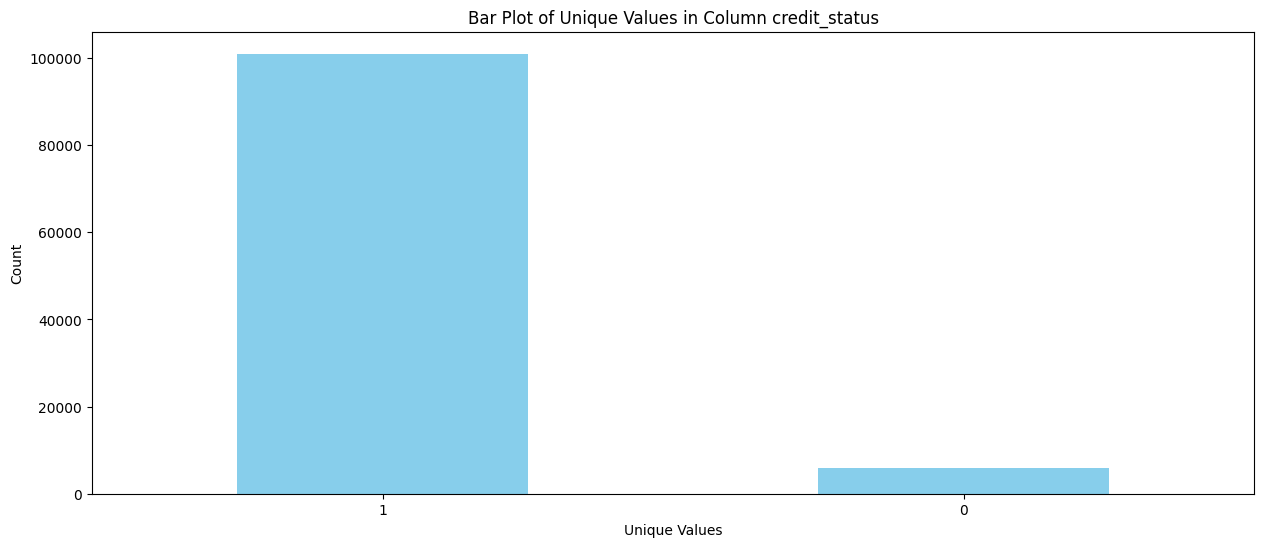

In [ ]:
# Count occurrences of each unique value in the column
value_counts = categorical_df['credit_status'].value_counts()

# Plotting
plt.figure(figsize=(15, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Unique Values in Column credit_status')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

##### Earliest Credit Line, Last Payment Date and Last Credit Pull Date atributes

Mengekstrak tanggal dengan format bulan dan tahun

In [ ]:
# Convert date strings to datetime objects
categorical_df['earliest_cr_line'] = pd.to_datetime(categorical_df['earliest_cr_line'], format='%b-%y').dt.strftime('%m-%y')
categorical_df['last_pymnt_d'] = pd.to_datetime(categorical_df['last_pymnt_d'], format='%b-%y').dt.strftime('%m-%y')
categorical_df['last_credit_pull_d'] = pd.to_datetime(categorical_df['last_credit_pull_d'], format='%b-%y').dt.strftime('%m-%y')

##### emp_length

In [ ]:
def process_emp_length(emp_length):
    if '10+' in emp_length:
        return 11
    elif '<1' in emp_length:
        return 0
    else:
        # Extract digits
        digits = ''.join(filter(str.isdigit, emp_length))
        # Check if digits is not empty
        return int(digits) if digits else 0

categorical_df['emp_length'] = categorical_df['emp_length'].apply(process_emp_length)

In [ ]:
def categorize_emp_length(value):
    if value >= 10:
        return ">10"
    else:
        return "<10"

# Categorize the processed values
categorical_df['emp_length'] = categorical_df['emp_length'].apply(categorize_emp_length)

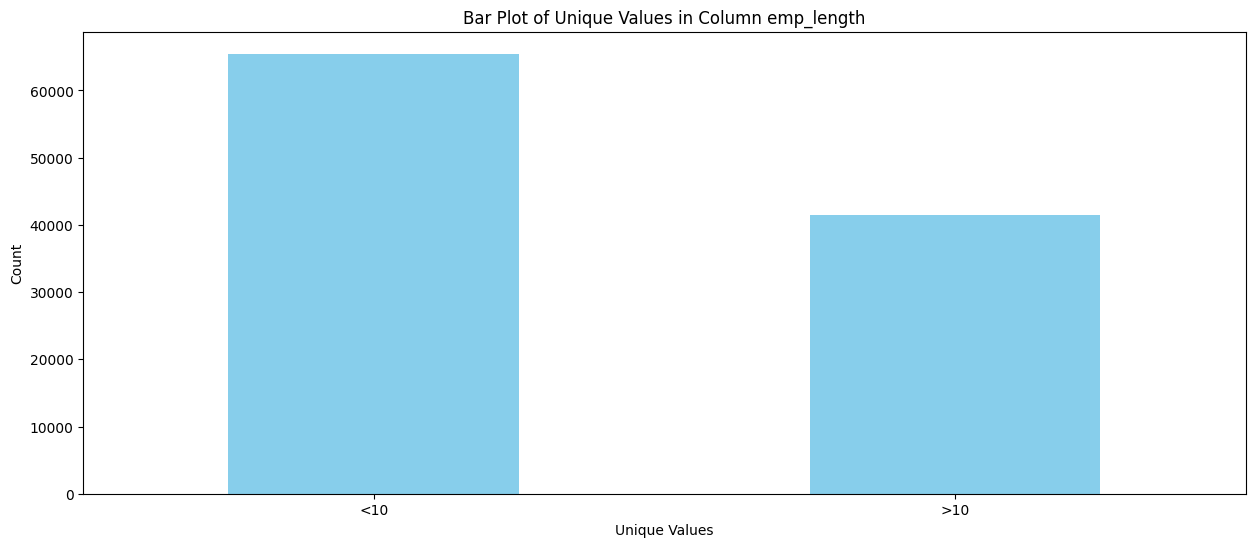

In [ ]:
# Count occurrences of each unique value in the column
value_counts = categorical_df['emp_length'].value_counts()

# Plotting
plt.figure(figsize=(15, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Unique Values in Column emp_length')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

##### Mengubah data string tanggal menjadi datetime

In [ ]:
# Convert to datetime format
categorical_df['last_pymnt_d'] = pd.to_datetime(categorical_df['last_pymnt_d'], format='%m-%y')
categorical_df['last_credit_pull_d'] = pd.to_datetime(categorical_df['last_credit_pull_d'], format='%m-%y')
categorical_df['earliest_cr_line'] = pd.to_datetime(categorical_df['earliest_cr_line'], format='%m-%y')

##### Mengekstrak fitur penilaian kredit dari fitur last creadit pull data dengan last payment date

* Penilaian 0 adalah penilaian dilakukan tepat setelah pembayaran kredit terakhir
* Penilaian 1-9 adalah penilaian dilakukan setelah 1 sampai 9 bulan setelah pembayaran kredit terakhir
* Penilaian 10+ adalah penilaian dilakukan setelah 10 atau lebih bulan setelah pembayaran kredit terakhir

In [ ]:
# Perform subtraction and convert to months
categorical_df['credit_assessment'] = ((categorical_df['last_credit_pull_d'] - categorical_df['last_pymnt_d']) / pd.Timedelta(days=30.44)).astype(int)

def categorize_emp_length(value):
    if value > 10:
        return "10+"
    elif value > 0:
        return "1-9"
    else:
        return "0"

# Categorize the processed values
categorical_df['credit_assessment'] = categorical_df['credit_assessment'].apply(categorize_emp_length)

categorical_df.drop(columns=['last_pymnt_d', 'last_credit_pull_d'], inplace=True)

##### Mengelompokkan setiap address state ke dalam region mereka masing-masing, seperti west coast, east coast, midwest, south

In [ ]:
region_mapping = {
    'West Coast': ['ca', 'or', 'wa', 'ak', 'co', 'nv'],
    'East Coast': ['nc', 'va', 'ct', 'fl', 'pa', 'nj', 'ky', 'sc', 'la', 'ma', 'ny', 'md', 'nh', 'ri'],
    'Midwest': ['il', 'mn', 'oh', 'wi', 'ks', 'mi'],
    'South': ['tx', 'az', 'ut', 'ga']
}

categorical_df['region'] = categorical_df['addr_state'].apply(lambda x: next((region for region, states in region_mapping.items() if x in states), 'Other'))

categorical_df.drop(columns=['addr_state'], inplace=True)

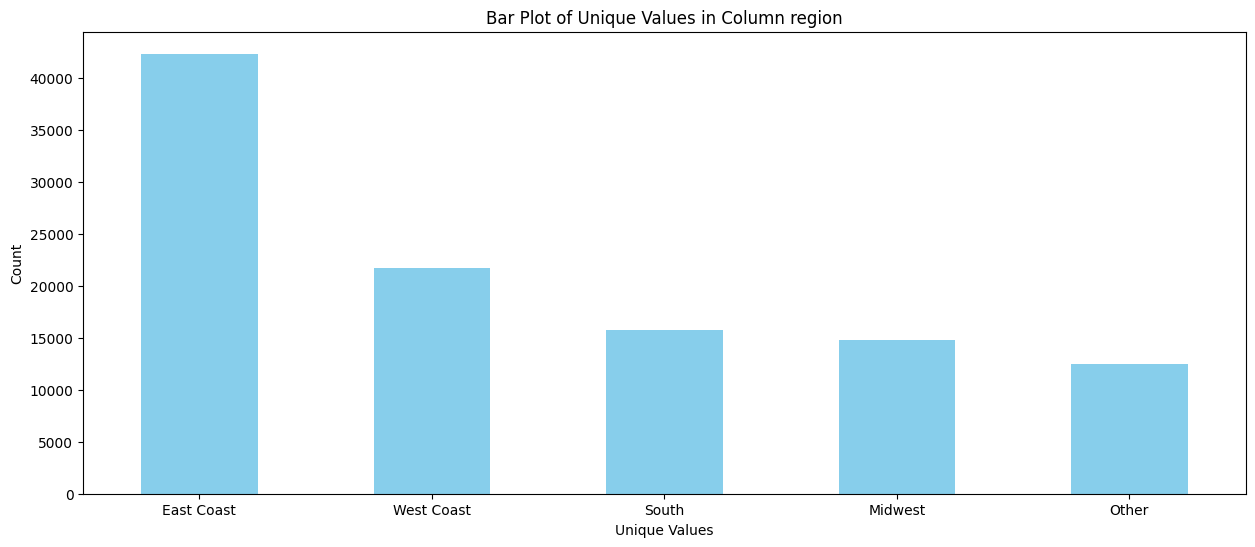

In [ ]:
# Count occurrences of each unique value in the column
value_counts = categorical_df['region'].value_counts()

# Plotting
plt.figure(figsize=(15, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Unique Values in Column region')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Convert all data in columns to lowercase
categorical_df = categorical_df.apply(lambda x: x.astype(str).str.lower())

In [ ]:
categorical_df_unique = categorical_df.nunique().sort_values(ascending=False)

# Mendapatkan name kolom-kolom yang berisi hanya satu nilai unik
half_unique_columns = []

for col in categorical_df_unique.index:
  if categorical_df_unique[col] > int(len(categorical_df)/2):
    half_unique_columns.append(col)
    print(f"{col}")

# Menghapus seluruh kolom yang hanya memiliki satu nilai unik
categorical_df = categorical_df.drop(columns=half_unique_columns)

### Encoding

In [ ]:
label_enc_columns = categorical_df.columns
label_enc = LabelEncoder()
for col in label_enc_columns:
    categorical_df[col] = label_enc.fit_transform(categorical_df[col])

### Normalization

In [ ]:
numeric_df = numeric_df.drop(columns=["pub_rec"])

In [ ]:
# Standard Scaler
standard_scaler = StandardScaler()
standard_columns = ['total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'int_rate', 'open_acc', 'total_acc', 'delinq_2yrs', 'inq_last_6mths']
# standard_columns = ['out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'int_rate', 'open_acc', 'total_acc', 'delinq_2yrs', 'inq_last_6mths']
numeric_df[standard_columns] = standard_scaler.fit_transform(numeric_df[standard_columns])

### Combine numeric and categorical dataframe

In [ ]:
# Join on index
df_combined = numeric_df.join(categorical_df, how='outer')

# Correlation and PCA

### Correlation

In [ ]:
# Compute the correlation matrix
correlation_matrix = df_combined.corr()

# Set a correlation threshold
threshold = 0.8

# Identify pairs with high correlation
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Count the pairs
num_high_corr_pairs = len(high_corr_pairs)

# Output results
print(f"Number of pairs with high correlation: {num_high_corr_pairs}")
print(f"Pairs of predictors with correlation above {threshold}:\n")

high_corr_pairs

Number of pairs with high correlation: 13
Pairs of predictors with correlation above 0.8:



[('funded_amnt', 'loan_amnt', 1.0),
 ('funded_amnt_inv', 'loan_amnt', 0.9999962248110299),
 ('funded_amnt_inv', 'funded_amnt', 0.9999962248110299),
 ('installment', 'loan_amnt', 0.9037941308765318),
 ('installment', 'funded_amnt', 0.9037941308765318),
 ('installment', 'funded_amnt_inv', 0.9037509765178027),
 ('last_pymnt_amnt', 'loan_amnt', 0.9311141180036125),
 ('last_pymnt_amnt', 'funded_amnt', 0.9311141180036125),
 ('last_pymnt_amnt', 'funded_amnt_inv', 0.9311056700188775),
 ('last_pymnt_amnt', 'installment', 0.9034739665587556),
 ('grade', 'int_rate', 0.9598290114459157),
 ('sub_grade', 'int_rate', 0.9840410283618658),
 ('sub_grade', 'grade', 0.9758904431514243)]

In [ ]:
# Step 2: Compute the correlation matrix
correlation_matrix = df_combined.corr()

# Step 3: Select the row corresponding to the dependent variable
dependent_variable = 'credit_status'
correlations_with_dependent = correlation_matrix[dependent_variable]

# Step 4: Set a correlation threshold and identify strong correlations
threshold = 0.5
# strong_correlations = correlations_with_dependent[abs(correlations_with_dependent) > threshold].drop(labels=[dependent_variable])
strong_correlations = correlations_with_dependent[correlations_with_dependent > threshold].drop(labels=[dependent_variable])

# Step 5: Count the number of strongly correlated independent variables
num_strong_correlations = len(strong_correlations)

# Output results
print(f"Number of independent variables with strong correlation with {dependent_variable}: {num_strong_correlations}")
print(f"Independent variables with correlation above {threshold}:\n", strong_correlations)

Number of independent variables with strong correlation with credit_status: 0
Independent variables with correlation above 0.5:
 Series([], Name: credit_status, dtype: float64)


### PCA

In [ ]:
# Separate the independent and dependent variables
dependent_variable = 'credit_status'
X = df_combined.drop(columns=[dependent_variable])  # Independent variables
y = df_combined[dependent_variable]  # Dependent variable

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Transform the data
# The transformed data is already stored in X_pca

# Output the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio of Each Principal Component:\n", explained_variance_ratio)

# Optionally, create a DataFrame for the PCA-transformed data
# This step is not necessary, but it may be useful for further analysis
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

Explained Variance Ratio of Each Principal Component:
 [6.57199301e-01 1.93054095e-01 6.70519511e-02 6.05374635e-02
 2.14089615e-02 5.87721333e-04 1.21373292e-04 2.86869941e-05
 5.06282996e-06 2.69489916e-06 2.15418848e-06 1.92829503e-07
 1.46176006e-07 1.26937926e-07 2.76727671e-08 2.23266636e-08
 1.38306037e-08 1.40101258e-09 8.93961019e-10 5.05893872e-10
 4.13454961e-10 4.11491829e-10 3.67087669e-10 2.37963998e-10
 2.09091900e-10 1.46964297e-10 9.80170769e-11 9.23218754e-11
 8.08345263e-11 4.16764495e-11 3.15622358e-11 2.13716803e-11
 1.10345905e-11 1.16785016e-14 3.30228910e-33 3.30228910e-33
 3.30228910e-33 3.30228910e-33 2.44776900e-33]


In [ ]:
# Join on index
df_after_pca = df_pca.join(y, how='outer')

# Third Data Preparation

### Data Splitting

In [ ]:
# Data Splitting untuk Logistic Regression
X_log = df_after_pca.drop('credit_status', axis=1)
y_log = df_after_pca['credit_status']

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

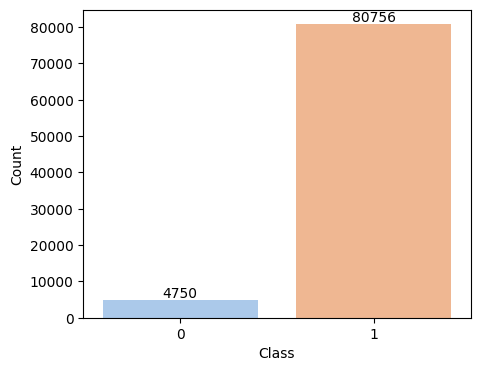

In [ ]:
# Untuk Logistic Regression
# Menghitung jumlah setiap nilai dalam y_train
value_counts_train_log = y_train_log.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train_log.index, y=value_counts_train_log.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train_log)):
    plt.text(i, value_counts_train_log[i], str(value_counts_train_log[i]), ha='center', va='bottom')

In [ ]:
X = df_combined.drop('credit_status', axis=1)
y = df_combined['credit_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

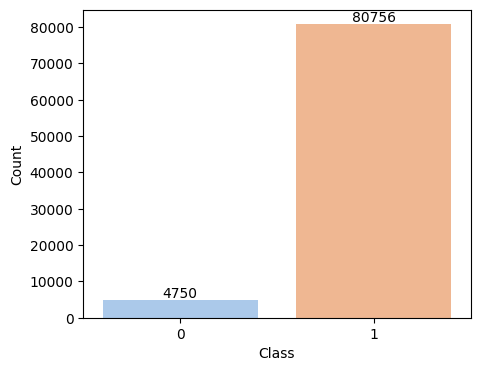

In [ ]:
# Menghitung jumlah setiap nilai dalam y_train
value_counts_train = y_train.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train.index, y=value_counts_train.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train)):
    plt.text(i, value_counts_train[i], str(value_counts_train[i]), ha='center', va='bottom')

### Oversampling

##### Oversampling untuk Logistic Regression

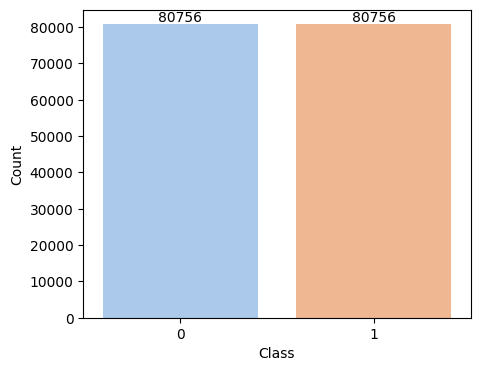

In [ ]:
# Oversampling menggunakan SMOTE
X_train_log_resampled, y_train_log_resampled = smote.fit_resample(X_train_log, y_train_log)

# Menghitung jumlah setiap nilai dalam y_train_resampled
value_counts_train_res_log = y_train_log_resampled.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train_res_log.index, y=value_counts_train_res_log.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train_res_log)):
    plt.text(i, value_counts_train_res_log[i], str(value_counts_train_res_log[i]), ha='center', va='bottom')

##### Oversampling untuk Stacking Ensemble Learning

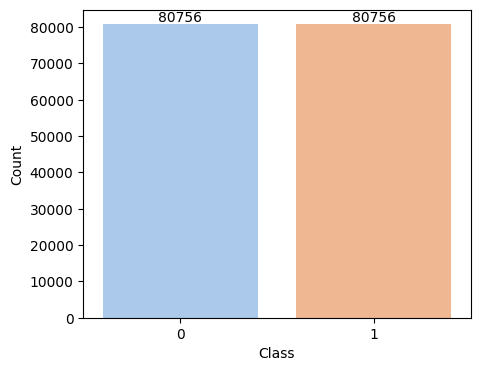

In [ ]:
# Oversampling menggunakan SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Menghitung jumlah setiap nilai dalam y_train_resampled
value_counts_train_res = y_train_resampled.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train_res.index, y=value_counts_train_res.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train_res)):
    plt.text(i, value_counts_train_res[i], str(value_counts_train_res[i]), ha='center', va='bottom')

# Model Selection

In [ ]:
# Inisialisasi model Logistic Regression
lg_model = LogisticRegression(random_state=42)

### Hyperparameter Tuning + Cross validation

##### HT untuk Logistic Regression

In [ ]:
# Define the grid of hyperparameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Solver algorithm
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Initialize GridSearchCV
log_model = GridSearchCV(estimator=lg_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

##### HT untuk Stacking Ensemble Learning

In [ ]:
random_grid_rf = {'n_estimators': [20,50,100,150], # Number of trees in the random forest
    'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)], # Maximum number of levels allowed in each decision tree
    'min_samples_split': [6, 10, 15], # Minimum sample number to split a node
    'min_samples_leaf': [3, 4, 6], # Minimum sample number that can be stored in a leaf node
    'bootstrap': [True, False] # Method used to sample data points
}
random_grid_xgb = {'max_depth': [2, 3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.1, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    'n_estimators': [50, 100, 250, 500]
}

# Randomized search on hyper parameters.
rf_random = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions = random_grid_rf,
    n_iter = 100,
    cv = 5,
    verbose = 2,
    random_state = 35,
    n_jobs = -1
)
xgb_random = RandomizedSearchCV(
    estimator = xgb.XGBClassifier(),
    param_distributions = random_grid_xgb,
    scoring = 'accuracy',
    n_iter = 25,
    n_jobs = 4,
    verbose = 1,
    error_score = 'raise'
)

In [ ]:
estimators = [
    ('random forest', rf_random),
    ('xgboost', xgb_random),
]

# Model Training

##### Logistic Regression Train

In [ ]:
# Measure time for GridSearchCV
start_time = time.time()
log_model.fit(X_train_log, y_train_log)
end_time = time.time()

# Calculate elapsed time
elapsed_time_gs = end_time - start_time

# Print the best hyperparameters
print("Best Hyperparameters:", log_model.best_params_)

# Get the best model
best_lr_model = log_model.best_estimator_

# Measure time for model evaluation
start_time = time.time()
accuracy = best_lr_model.score(X_test_log, y_test_log)
end_time = time.time()

# Calculate elapsed time for model evaluation
elapsed_time_eval = end_time - start_time

# Print accuracy and elapsed times
print("Accuracy on training set:", accuracy)
print(f"Waktu komputasi selama training: {elapsed_time_gs:.4f} seconds")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy on training set: 0.9469991111942743
Waktu komputasi selama training: 3567.9940 seconds


##### Other Algorithms Train

In [ ]:
def trainingProcess(evaluation_information, name, model, X_train, y_train, save_model = False):
  start_time = time.time()
  model.fit(X_train, y_train)
  # Save the fitted model to a file
  if save_model:
    joblib_file = "fitted_model.pkl"
    joblib.dump(model, joblib_file)
    print("Model has been saved to", joblib_file)
  end_time = time.time()

  mod_t = end_time - start_time

  evaluation_information['ct'].append(mod_t)
  evaluation_information['name'].append(name)
  evaluation_information['model'].append(model)

  return evaluation_information

In [ ]:
training_information = {
    'name': [],
    'ct': [],
    'model': []
}
for name, model in estimators:
  training_information = trainingProcess(training_information, name, model, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Model Testing

### Logistic Regression Testing

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred = log_model.predict(X_test_log)

# Evaluate the model
accuracy = accuracy_score(y_test_log, y_pred)
print(f'Accuracy: {accuracy}')

# Detailed classification report
print(classification_report(y_test_log, y_pred))

Accuracy: 0.9469991111942743
              precision    recall  f1-score   support

           0       0.68      0.04      0.07      1155
           1       0.95      1.00      0.97     20222

    accuracy                           0.95     21377
   macro avg       0.81      0.52      0.52     21377
weighted avg       0.93      0.95      0.92     21377



### Other Algorithms

In [ ]:
def testingProcess(evaluation_information, name, model, X_test, y_test):
  start_time = time.time()
  prediction = model.predict(X_test)
  end_time = time.time()

  mod_t = end_time - start_time

  evaluation_information['ct'].append(mod_t)

  evaluation_information['name'].append(name)

  acc = metrics.accuracy_score(y_test, prediction)
  evaluation_information['acc'].append(acc)

  precision = metrics.precision_score(y_test, prediction, pos_label=1, average='weighted')  # calculate precision
  evaluation_information['prec'].append(precision)

  recall_sensitivity = metrics.recall_score(y_test, prediction, pos_label=1, average='weighted')  # calculate recall sensitivity
  evaluation_information['recall'].append(recall_sensitivity)

  f1 = metrics.f1_score(y_test, prediction, pos_label=1, average='weighted')  # calculate f1 score
  evaluation_information['f1'].append(f1)

  evaluation_information['conf_m'].append(prediction)

  return evaluation_information

In [ ]:
testing_information = {
    'name': [],
    'acc': [],
    'prec': [],
    'recall': [],
    'f1': [],
    'ct': [],
    'conf_m': []
}

length = len(training_information['model'])
for x in range(length):
  testing_information = testingProcess(
      testing_information,
      training_information['name'][x],
      training_information['model'][x],
      X_test,
      y_test
  )

# Evaluation

### Confusion Matrix

##### Logistic Regression

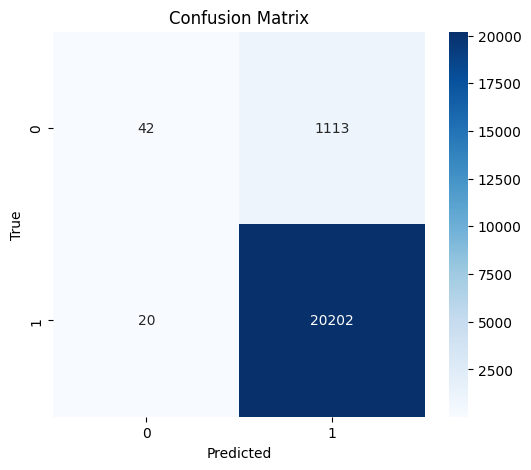

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=log_model.classes_, yticklabels=log_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### Random Forest, GBDT, dan XGBoost

In [ ]:
# Generate confusion matrix
def show_confusion_matrix(title, y_test, testing_information, numb, model):
  conf_matrix = confusion_matrix(y_test, testing_information['conf_m'][numb])

  # Plotting confusion matrix
  plt.figure(figsize=(5, 4))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
  plt.title(f'Confusion Matrix {title}')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

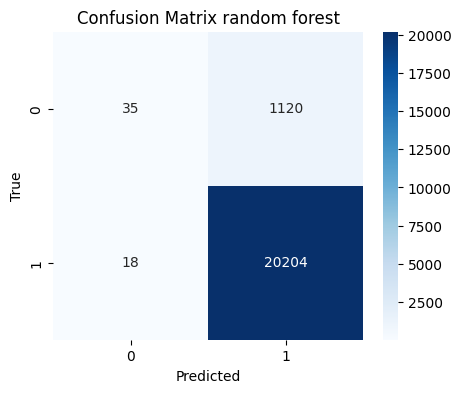

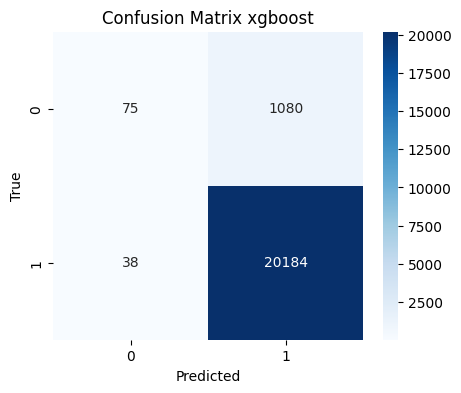

In [ ]:
length = len(testing_information['name'])
for x in range(length):
  show_confusion_matrix(
      training_information['name'][x],
      y_test,
      testing_information,
      x,
      training_information['model'][x]
  )

### Precision Recall

##### Logistic regression

In [ ]:
# Confusion Matric untuk Logistik Regression
print('Precision Score: ', precision_score(y_test, y_pred))
print('Recall Score: ', recall_score(y_test, y_pred))

Precision Score:  0.9477832512315271
Recall Score:  0.999010978142617


##### Informasi training dari model random forest, GBDT dan XGBoost

In [ ]:
training_information = pd.DataFrame(training_information)
training_information.iloc[:, :2]

,name,ct
0,random forest,9097.700147
1,xgboost,433.722175


##### Informasi testing dari model random forest, GBDT dan XGBoost

In [ ]:
testing_information = pd.DataFrame(testing_information)
testing_information.iloc[:, :6]

,name,acc,prec,recall,f1,ct
0,random forest,0.946765,0.931965,0.946765,0.923189,0.390894
1,xgboost,0.947701,0.933785,0.947701,0.926869,0.101728


### ROC Curve

##### Logistic Regression

ROC AUC: 0.8728294716525357


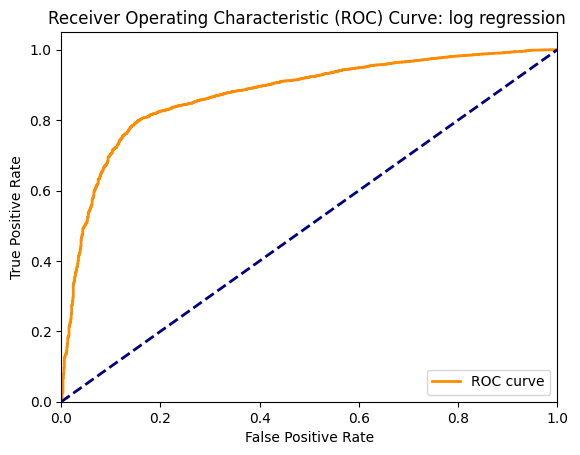

In [ ]:
# Predict probabilities for the test set
y_probs = log_model.predict_proba(X_test_log)[:, 1]  # Probabilities of the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_log, y_probs)
roc_auc = roc_auc_score(y_test_log, y_probs)
print("ROC AUC:", roc_auc)

name = "log regression"

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve: {name} ')
plt.legend(loc="lower right")
plt.show()

##### ROC Random Forest, GBDT, dan XGBoost

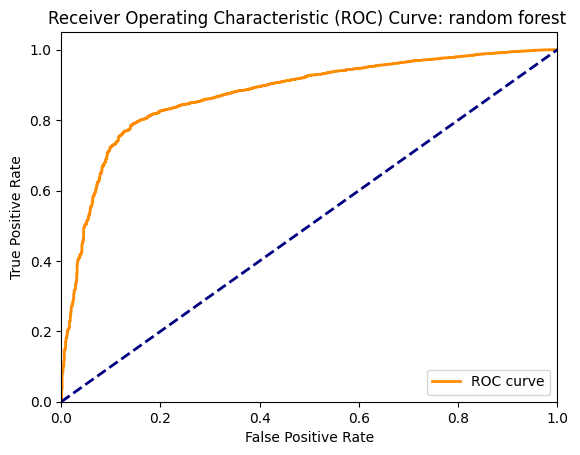

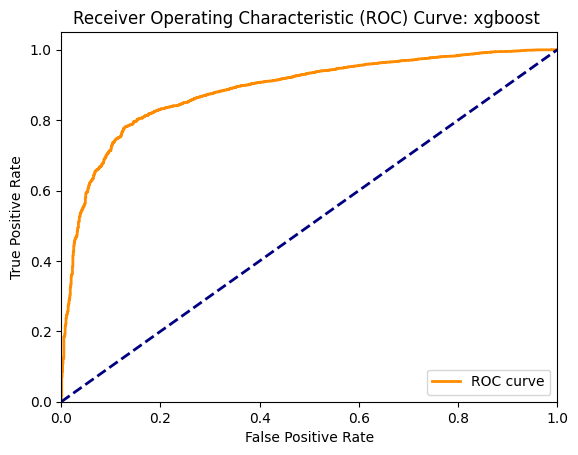

In [ ]:
for x in range(length):
  # Predict probabilities for the test set
  y_probs = training_information['model'][x].predict_proba(X_test)[:, 1]  # Probabilities of the positive class

  # Calculate ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_probs)

  name = training_information['name'][x]

  # Plot ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve: {name} ')
  plt.legend(loc="lower right")
  plt.show()

### Area Under Curve (AUC)

##### AUC Logistic Regression

In [ ]:
# Predict probabilities for the test set
y_probs = log_model.predict_proba(X_test_log)[:, 1]  # Probabilities of the positive class

# Step 5: Calculate AUC
auc = roc_auc_score(y_test_log, y_probs)
name = 'Log Regression'
print(f"AUC {name}: {auc}")

AUC Log Regression: 0.8728294716525357


##### AUC Random Forest, GBDT, XGBoost

In [ ]:
for x in range(length):
  # Predict probabilities for the test set
  y_probs = training_information['model'][x].predict_proba(X_test)[:, 1]  # Probabilities of the positive class

  # Step 5: Calculate AUC
  auc = roc_auc_score(y_test, y_probs)
  name = training_information['name'][x]
  print(f"AUC {name}: {auc}")

AUC random forest: 0.8730596011972731
AUC xgboost: 0.884811878195322
